In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az

In [29]:
def standardize_data(X):
    return (X - np.mean(X)) / np.std(X)

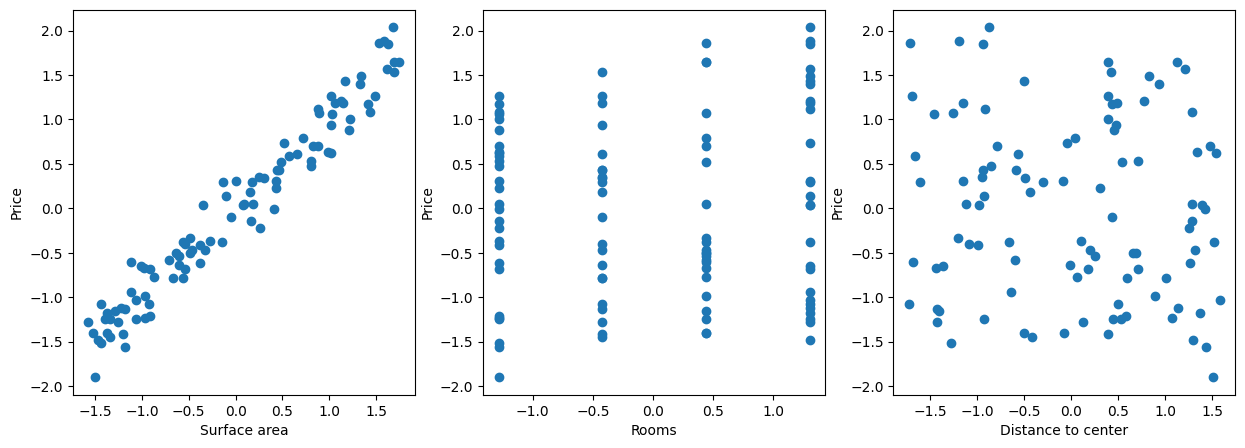

In [30]:
df = pd.read_csv('real_estate_data.csv')
df.dropna(inplace=True)


y = df['Price'].values.astype(float)
y_std = y.std()
y_mean = y.mean()
y = standardize_data(y)
x1 = df['Surface_area'].values.astype(float)
x1_std = x1.std()
x1_mean = x1.mean()
x1 = standardize_data(x1)
x2 = df['Rooms'].values.astype(float)
x2_std = x2.std()
x2_mean = x2.mean()
x2 = standardize_data(x2)
x3 = df['Distance_to_center'].values.astype(float)
x3_std = x3.std()
x3_mean = x3.mean()
x3 = standardize_data(x3)

_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(x1, y)
ax[0].set_xlabel('Surface area')
ax[0].set_ylabel('Price')
ax[1].scatter(x2, y)
ax[1].set_xlabel('Rooms')
ax[1].set_ylabel('Price')
ax[2].scatter(x3, y)
ax[2].set_xlabel('Distance to center')
ax[2].set_ylabel('Price')

plt.show()

In [31]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    beta3 = pm.Normal('beta3', mu=0, sigma=10)

    # distributia student pt a elimina valorile aberante
    eps = pm.HalfNormal('eps', sigma=10)
    mu = pm.Deterministic('mu', alpha + beta1 * x1 + beta2 * x2 + beta3 * x3)
    y_pred = pm.StudentT('y_pred', mu=mu, sigma=eps, nu=20, observed=y)

    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, eps]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


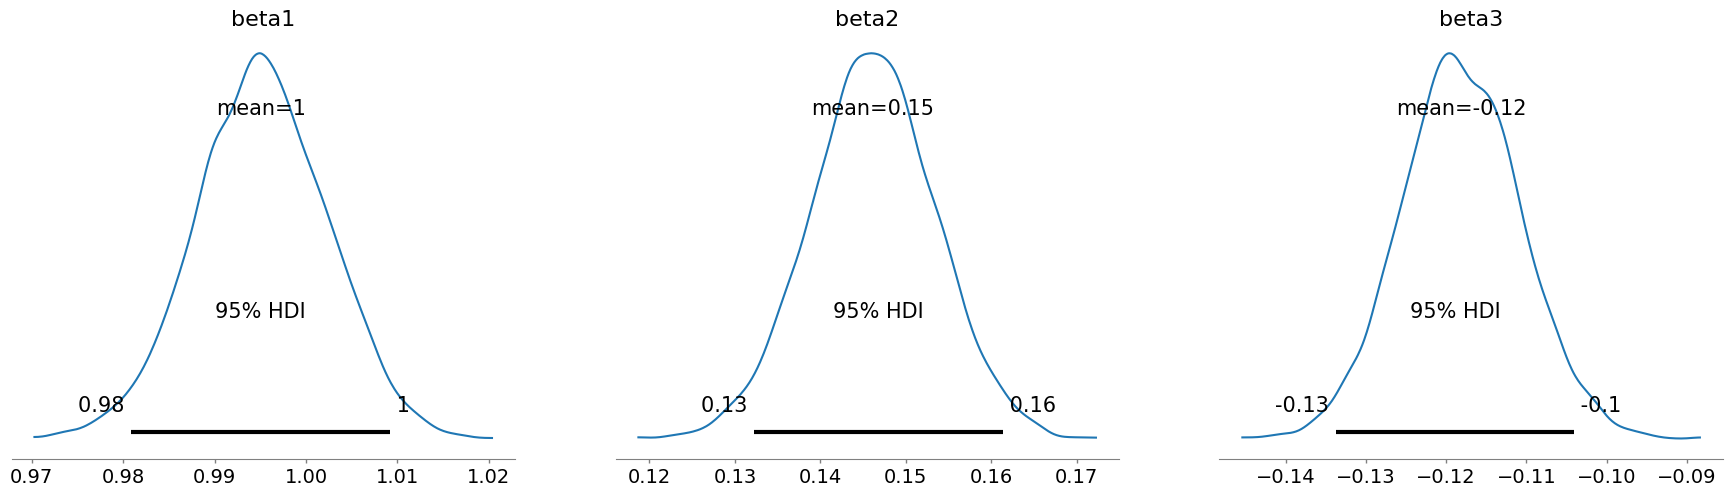

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -0.000  0.008  -0.014    0.014        0.0      0.0    5597.0    3276.0   
beta1  0.995  0.007   0.981    1.008        0.0      0.0    5044.0    3333.0   
beta2  0.146  0.007   0.132    0.160        0.0      0.0    6300.0    3368.0   
beta3 -0.118  0.008  -0.132   -0.104        0.0      0.0    5121.0    3355.0   

       r_hat  
alpha    1.0  
beta1    1.0  
beta2    1.0  
beta3    1.0  


In [32]:
az.plot_posterior(trace, var_names=['beta1', 'beta2', 'beta3'], hdi_prob=0.95)
plt.show()
print(az.summary(trace, var_names=['alpha', 'beta1', 'beta2', 'beta3']))

In [33]:
def predict_price(trace_p, x1_p, x2_p, x3_p):
    x1_p_std = (x1_p - x1_mean) / x1_std
    x2_p_std = (x2_p - x2_mean) / x2_std
    x3_p_std = (x3_p - x3_mean) / x3_std
    posterior = trace_p.posterior.stack(sample=("chain", "draw"))
    alpha_s = posterior["alpha"].values.flatten()
    beta1_s = posterior["beta1"].values.flatten()
    beta2_s = posterior["beta2"].values.flatten()
    beta3_s = posterior["beta3"].values.flatten()
    
    y_pred_s = alpha_s + beta1_s * x1_p_std + beta2_s * x2_p_std + beta3_s * x3_p_std
    return y_pred_s

<Axes: title={'center': 'x'}>

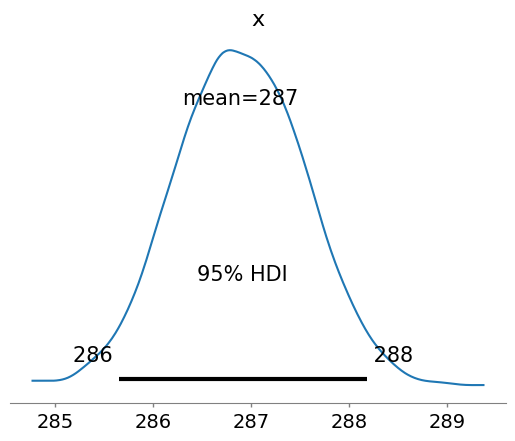

In [40]:
pred_x1 = [100] # surface
pred_x2 = [2] # rooms
pred_x3 = [4.5] # distance

pred_samples = predict_price(trace, pred_x1, pred_x2, pred_x3) * y_std + y_mean
az.plot_posterior(pred_samples, hdi_prob=0.95)